In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Position Classification by CNN**

Loading images / 画像読み込み中: 100%|██████████| 1838/1838 [00:58<00:00, 31.48it/s] 


Number of classes: 11
Epoch 1/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 169s 4s/step - accuracy: 0.2974 - loss: 5.4719 - val_accuracy: 0.7463 - val_loss: 0.7932
Epoch 2/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 146s 3s/step - accuracy: 0.7885 - loss: 0.6726 - val_accuracy: 0.7345 - val_loss: 0.7958
Epoch 3/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 140s 3s/step - accuracy: 0.9280 - loss: 0.2616 - val_accuracy: 0.7257 - val_loss: 0.8748
Epoch 4/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 143s 3s/step - accuracy: 0.9763 - loss: 0.0922 - val_accuracy: 0.7139 - val_loss: 1.0881
Epoch 5/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 135s 3s/step - accuracy: 0.9918 - loss: 0.0351 - val_accuracy: 0.6873 - val_loss: 1.1622
Epoch 6/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 131s 3s/step - accuracy: 0.9962 - loss: 0.0270 - val_accuracy: 0.6785 - val_loss: 1.2610
Epoch 7/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 142s 3s/step - accuracy: 0.9987 - loss: 0.0138 - val_accuracy: 0.6844 - val_loss: 1.4905
Epoch 8/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 129s 3s/step - accuracy: 0.9987 - loss: 0.0139 - va

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


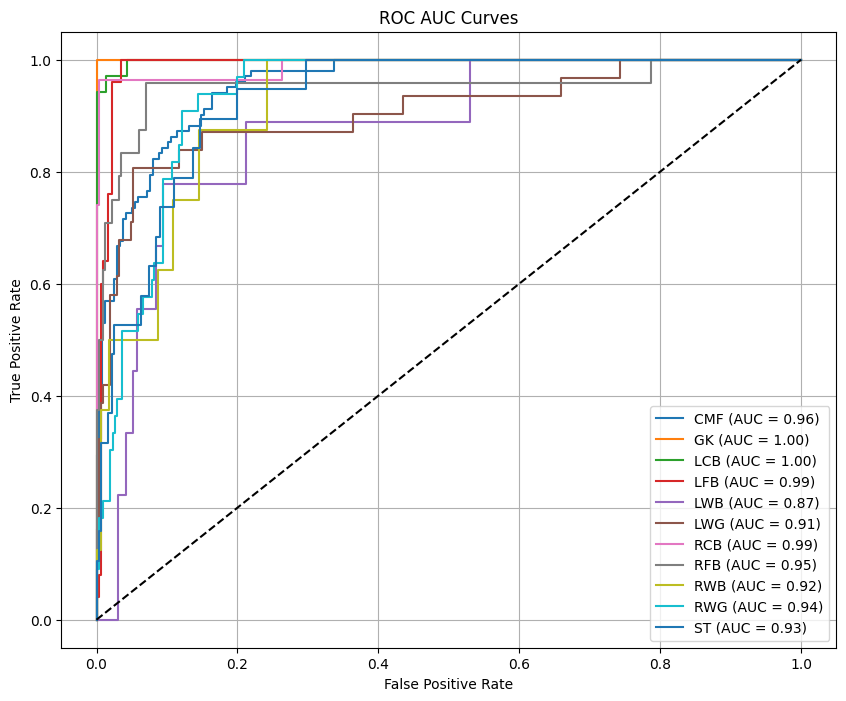

In [3]:
# Import necessary libraries / 必要なライブラリのインポート
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from tensorflow.keras.utils import to_categorical

# Load CSV containing match_id, player_id, and small_class labels
# match_id, player_id, small_class を含むCSVを読み込む
csv_path = '/content/drive/MyDrive/MIT_Sloan/position_stats_mean_per_min_small_class.csv'
df_labels = pd.read_csv(csv_path)

# Create label mapping: match_id + player_id → small_class
# ラベルマッピングを作成（match_id + player_id → small_class）
label_map = {}
for _, row in df_labels.iterrows():
    key = f"{int(row['match_id'])}_{int(row['player_id'])}"
    label_map[key] = row['small_class']

# Define folder containing heatmap images
# ヒートマップ画像が保存されているフォルダを定義
image_folder = '/content/drive/MyDrive/MIT_Sloan/heatmaps_all/'

# Initialize lists for image data and labels
# 画像データとラベルを格納するリストを初期化
X, y = [], []

# Load and process images / 画像を読み込み・処理
image_files = [f for f in os.listdir(image_folder) if f.endswith('.png')]
for f in tqdm(image_files, desc="Loading images / 画像読み込み中"):
    parts = f.split('_')
    if len(parts) >= 6:
        match_id = parts[3]
        player_id = parts[5].split('.')[0]
        key = f"{match_id}_{player_id}"
        if key in label_map:
            label = label_map[key]
            img_path = os.path.join(image_folder, f)
            img_data = tf.io.read_file(img_path)
            img_data = tf.io.decode_png(img_data, channels=3)
            img_data = tf.image.resize(img_data, [224, 224])
            img_data = img_data.numpy() / 255.0  # Normalize / 正規化
            X.append(img_data)
            y.append(label)

# Convert to NumPy arrays / NumPy配列に変換
X = np.array(X)
y = np.array(y)

# Encode labels to integers / ラベルを整数にエンコード
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Split into train and test sets / 学習用とテスト用に分割
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Get number of classes / クラス数を取得
num_classes = len(np.unique(y_train))
target_names = le.classes_.tolist()
print("Number of classes:", num_classes)

# Define CNN model / CNNモデルを定義
base_model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(224, 224, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

# Compile model / モデルをコンパイル
base_model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Train model and save history / モデルを学習し履歴を保存
history = base_model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), batch_size=32)

# Find best epoch based on validation accuracy / 最良エポックを特定
best_epoch = np.argmax(history.history['val_accuracy']) + 1
print(f"Best epoch based on validation accuracy: {best_epoch}")

# Re-train model using best epoch / 最良エポックまで再学習
model = tf.keras.models.clone_model(base_model)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.fit(X_train, y_train, epochs=best_epoch, validation_data=(X_test, y_test), batch_size=32)

# Predict and evaluate / 予測と評価
y_pred_probs = model.predict(X_test)  # Softmax probabilities / Softmax確率
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Classification report / 分類レポート
print("📊 Classification Report:")
report = classification_report(y_test, y_pred_classes, target_names=target_names, output_dict=True)
for label, metrics in report.items():
    if isinstance(metrics, dict):
        print(f"{label}: Precision={metrics['precision']:.2f}, Recall={metrics['recall']:.2f}, F1-score={metrics['f1-score']:.2f}")

# Confusion matrix / 混同行列
conf_matrix = confusion_matrix(y_test, y_pred_classes)
print("\n🧩 Confusion Matrix:")
print(conf_matrix)

# Accuracy per class / クラスごとの正解率
print("\n🎯 Accuracy per class:")
for i in range(conf_matrix.shape[0]):
    correct = conf_matrix[i, i]
    total = np.sum(conf_matrix[i, :])
    acc = correct / total if total > 0 else 0
    print(f"{target_names[i]}: Accuracy = {acc:.2f}")

# Specificity and False Positive Rate / 特異度と偽陽性率
print("\n🔍 Specificity and 🚫 False Positive Rate per class:")
for i in range(conf_matrix.shape[0]):
    tn = np.sum(np.delete(np.delete(conf_matrix, i, axis=0), i, axis=1))
    fp = np.sum(np.delete(conf_matrix[i, :], i))
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    print(f"{target_names[i]}: Specificity = {specificity:.2f}, FPR = {fpr:.2f}")

# ROC AUC curves / ROC AUC曲線の描画
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve((y_test == i).astype(int), y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{target_names[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC Curves')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

**Output of CNN Model Performance Metrics（CNNモデル精度指標の出力）**

In [5]:
# Import necessary libraries / 必要なライブラリのインポート
from sklearn.metrics import classification_report  # For performance metrics / 精度指標の算出
import pandas as pd  # For DataFrame handling / データフレーム操作
import numpy as np  # For numerical operations / 数値処理

# Predict class labels from CNN model (Softmax output → class index)
# CNNモデルの予測（Softmax出力 → クラスラベル）
y_pred_probs_cnn = model.predict(X_test)
y_pred_cnn = np.argmax(y_pred_probs_cnn, axis=1)

# Generate classification report as dictionary
# 分類レポートを辞書形式で取得
cnn_report = classification_report(y_test, y_pred_cnn, output_dict=True)

# Extract key performance metrics from report
# レポートから主要な精度指標を抽出
cnn_metrics = {
    'Model': 'CNN',  # モデル名
    'Accuracy': round(cnn_report['accuracy'], 3),  # 全体の正解率
    'Macro Precision': round(cnn_report['macro avg']['precision'], 3),  # マクロ平均の適合率
    'Macro Recall': round(cnn_report['macro avg']['recall'], 3),  # マクロ平均の再現率
    'Macro F1-score': round(cnn_report['macro avg']['f1-score'], 3),  # マクロ平均のF1スコア
    'Weighted Precision': round(cnn_report['weighted avg']['precision'], 3),  # 重み付き平均の適合率
    'Weighted Recall': round(cnn_report['weighted avg']['recall'], 3),  # 重み付き平均の再現率
    'Weighted F1-score': round(cnn_report['weighted avg']['f1-score'], 3)  # 重み付き平均のF1スコア
}

# Convert metrics to DataFrame for display
# 精度指標をデータフレームに変換して表示
df_cnn_metrics = pd.DataFrame([cnn_metrics])

# Display metrics for MIT paper
# MIT論文用に精度指標を表示
print("📊 CNNモデル精度指標（MIT論文用）")
display(df_cnn_metrics)

11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 709ms/step
📊 CNNモデル精度指標（MIT論文用）


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,Model,Accuracy,Macro Precision,Macro Recall,Macro F1-score,Weighted Precision,Weighted Recall,Weighted F1-score
0,CNN,0.74,0.645,0.615,0.579,0.743,0.74,0.706


**Visualization of Confusion Matrix （混同行列の作図）**

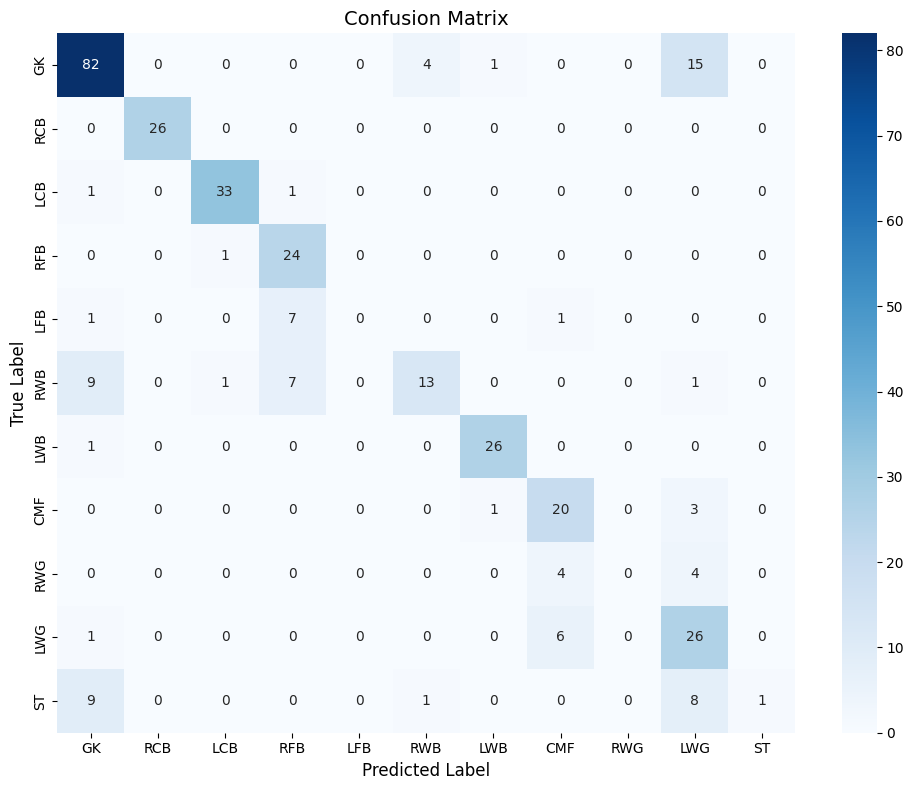

In [6]:
# Import necessary libraries / 必要なライブラリのインポート
import seaborn as sns  # For heatmap visualization / ヒートマップ描画用
import matplotlib.pyplot as plt  # For plotting / グラフ描画用
from sklearn.metrics import confusion_matrix  # For confusion matrix / 混同行列の作成
import numpy as np  # For numerical operations / 数値処理

# Define class names (11 football positions)
# クラス名（11ポジション）を定義
target_names = ['GK', 'RCB', 'LCB', 'RFB', 'LFB', 'RWB', 'LWB', 'CMF', 'RWG', 'LWG', 'ST']

# Create confusion matrix from true and predicted labels
# 正解ラベルと予測ラベルから混同行列を作成
cm = confusion_matrix(y_test, y_pred_classes)

# Plot confusion matrix as heatmap
# 混同行列をヒートマップとして描画
plt.figure(figsize=(10, 8))  # Set figure size / 図のサイズを設定
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)  # ヒートマップ描画

# Add axis labels and title / 軸ラベルとタイトルを追加
plt.xlabel('Predicted Label', fontsize=12)  # 予測ラベル
plt.ylabel('True Label', fontsize=12)       # 正解ラベル
plt.title('Confusion Matrix', fontsize=14)  # タイトル
plt.tight_layout()  # レイアウト調整
plt.show()  # グラフ表示

**Class-wise Performance Summary Table （クラス別精度表）**

In [7]:
# Import necessary libraries / 必要なライブラリのインポート
from sklearn.metrics import classification_report  # For generating performance metrics / 精度指標の生成
import pandas as pd  # For DataFrame handling / データフレーム操作

# Define class names (11 football positions)
# クラス名（11ポジション）を定義
target_names = ['GK', 'RCB', 'LCB', 'RFB', 'LFB', 'RWB', 'LWB', 'CMF', 'RWG', 'LWG', 'ST']

# Generate classification report as dictionary
# 分類レポートを辞書形式で取得
report_dict = classification_report(y_test, y_pred_classes, target_names=target_names, output_dict=True)

# Extract only per-class metrics (exclude macro/weighted averages)
# クラス別の指標のみ抽出（macro avgやweighted avgは除外）
class_metrics = {label: report_dict[label] for label in target_names}

# Convert to DataFrame and select precision, recall, F1-score
# データフレーム化し、precision, recall, F1-score の列を抽出
df_metrics = pd.DataFrame(class_metrics).T[['precision', 'recall', 'f1-score']]
df_metrics = df_metrics.round(3)  # Round to 3 decimal places / 小数第3位で丸め

# Display the class-wise performance table
# クラス別精度表を表示
print("✅ Class-wise Performance Table (F1-score, Precision, Recall) / クラス別精度表（F1-score, Precision, Recall）")
display(df_metrics)

✅ Class-wise Performance Table (F1-score, Precision, Recall) / クラス別精度表（F1-score, Precision, Recall）


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,precision,recall,f1-score
GK,0.788,0.804,0.796
RCB,1.000,1.000,1.000
LCB,0.943,0.943,0.943
RFB,0.615,0.960,0.750
LFB,0.000,0.000,0.000
RWB,0.722,0.419,0.531
LWB,0.929,0.963,0.945
CMF,0.645,0.833,0.727
RWG,0.000,0.000,0.000
LWG,0.456,0.788,0.578


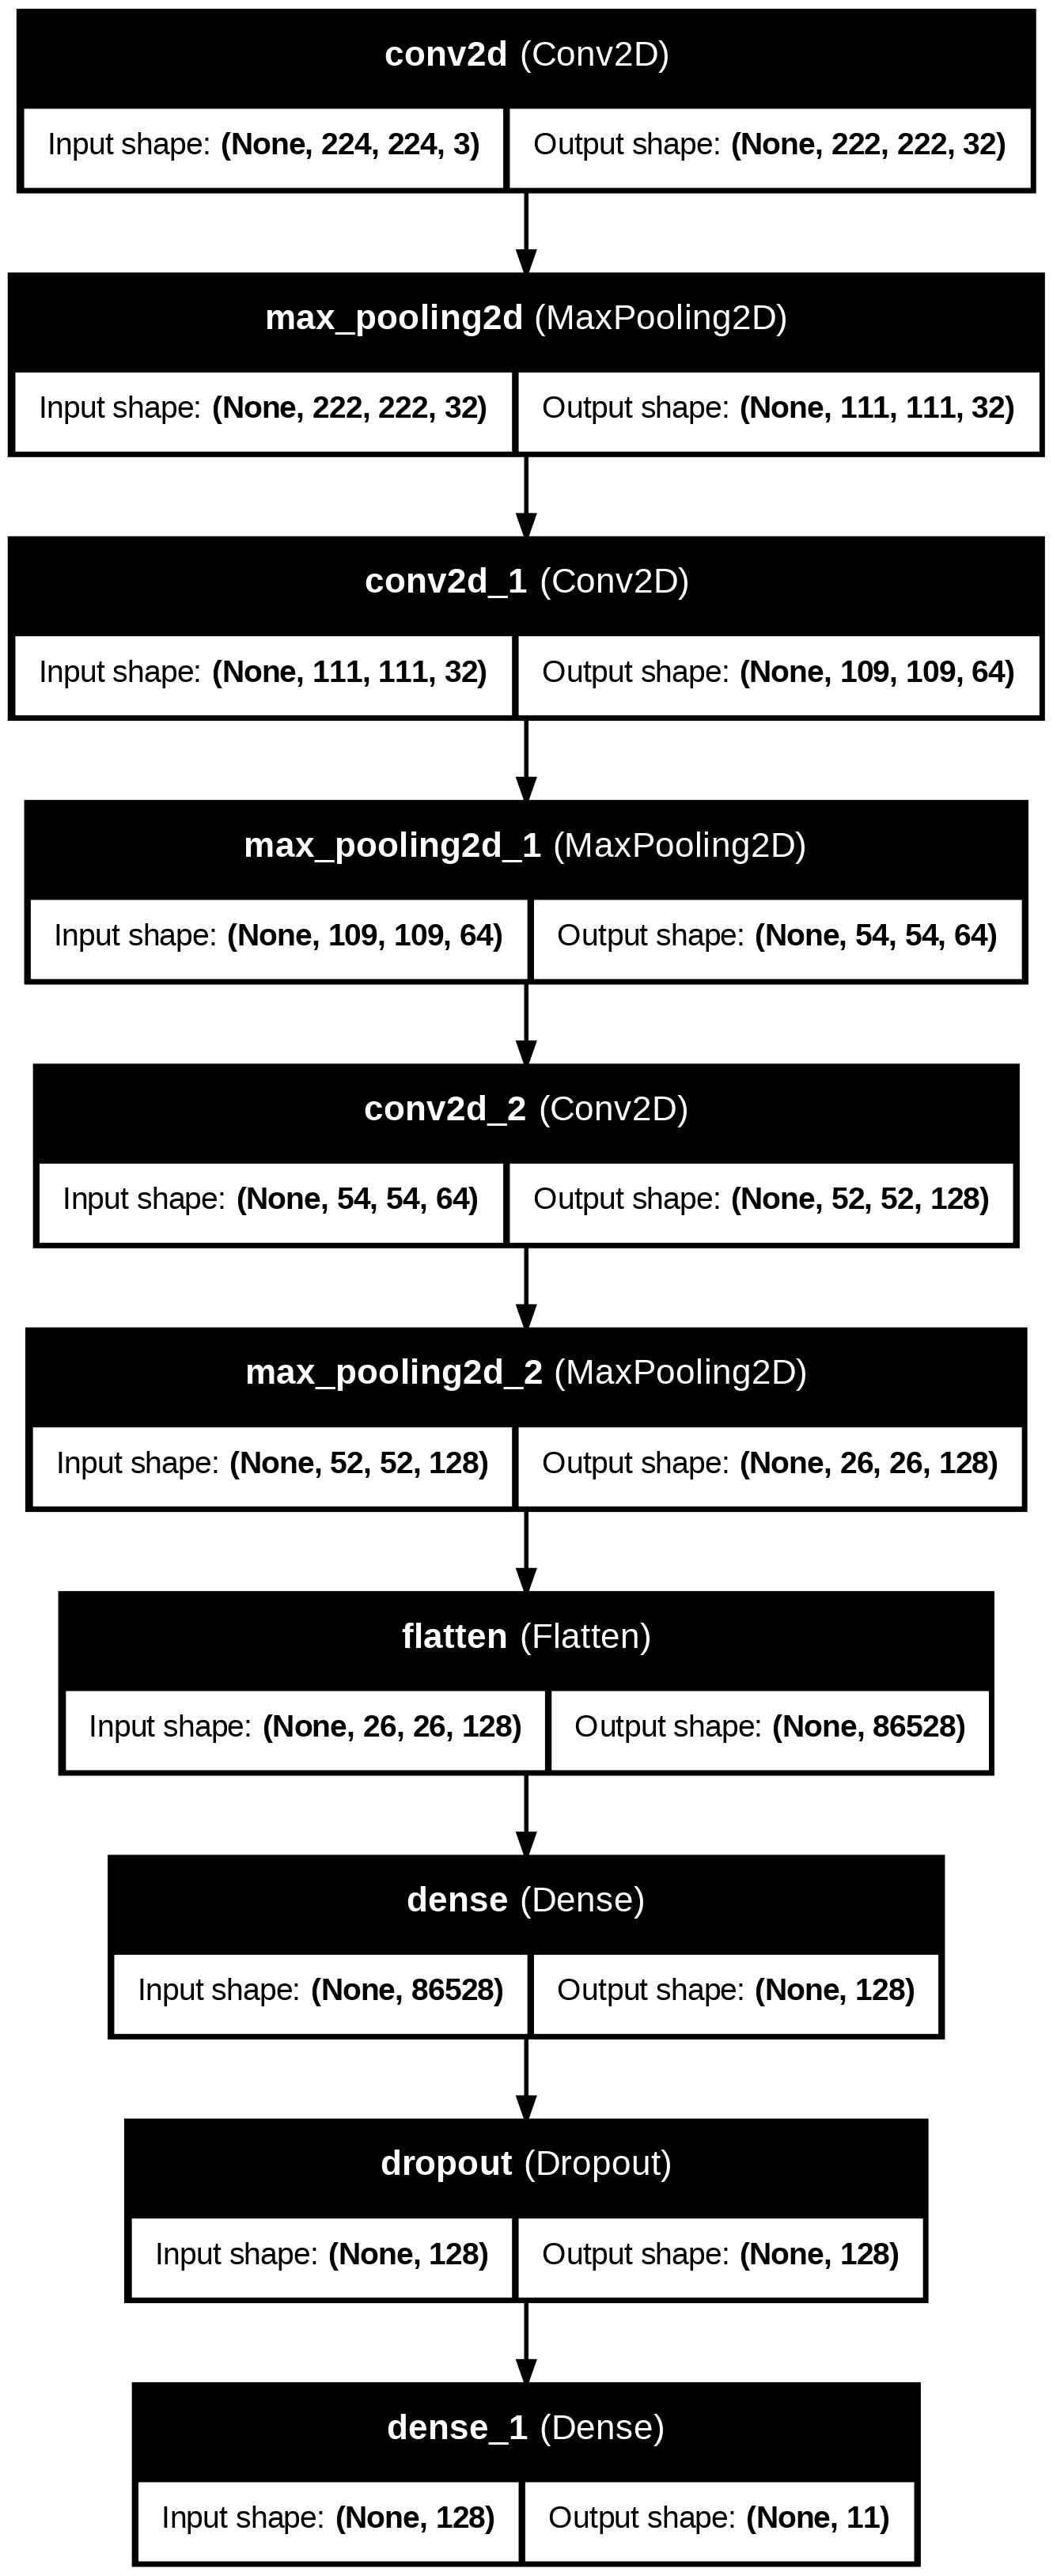

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(11, activation='softmax')  # 11ポジション分類
])

from tensorflow.keras.utils import plot_model
plot_model(model, to_file='/content/drive/MyDrive/cnn_model_structure.png', show_shapes=True, show_layer_names=True)
